In [1]:
# Load packages
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support
from models import NeuralNetwork, TrainConfig, evaluate_nn_model, save_model, load_model, plot_results
from utils import load_data, split_data, encode_data, mapping_dict
from pathlib import Path
import altair as alt
import pandas as pd

from tqdm import tqdm

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("Device: cuda")
        print(torch.cuda.get_device_name(i))
else:
    print("Device: cpu")

Device: cpu


# Load data

In [5]:
file_list_balkan = [
    'power-ua-train.tsv',
    'power-fr-train.tsv',
    'power-nl-train.tsv',
]

data_gb = load_data(folder_path="data/train/power/", file_list=['power-gb-train.tsv'],text_head='text_en')
data_hr = load_data(folder_path="data/train/power/", file_list=['power-hr-train.tsv'],text_head='text_en')
data_balkan = load_data(folder_path="data/train/power/", file_list=file_list_balkan,text_head='text_en')

train_raw_gb, test_raw_gb = split_data(data_gb, test_size=0.2, random_state=0)
train_raw_hr, test_raw_hr = split_data(data_hr, test_size=0.2, random_state=0)
train_raw_balkan, test_raw_balkan = split_data(data_gb, test_size=0.2, random_state=0)


# Encode

In [6]:

print("Prepare data encoder...")
encoder_gb = TfidfVectorizer(max_features=50000)
encoder_gb.fit(train_raw_gb.texts)

print("Prepare data...")
train_gb = encode_data(train_raw_gb, encoder_gb)
test_gb = encode_data(test_raw_gb, encoder_gb)

Prepare data encoder...
Prepare data...


# Neural Networks

In [7]:
# POC

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

dataloader_gb = DataLoader(train_gb, batch_size=128, shuffle=True)

USE_CACHE = False

model_nn_gb = NeuralNetwork(
    input_size=len(encoder_gb.vocabulary_),
    hidden_size=128,
    device='cpu'
)

if Path('models/model_nn_gb.pt').exists() and USE_CACHE:
    model_nn_gb = load_model(model_nn_gb, 'model_nn_gb')
else:
    model_nn_gb.fit(dataloader_gb, train_config, disable_progress_bar=False)
    save_model(model_nn_gb, "model_nn_gb")

model_nn_gb_results = evaluate_nn_model(model_nn_gb, test_gb)
np.save('models/model_nn_gb_results.npy', model_nn_gb_results)
print(model_nn_gb_results)


# Plot training accuracy and loss side-by-side
plot_results(model_nn_gb, train_config, dataloader_gb)

Train model



Epoch 10: 100%|██████████| 209/209 [00:05<00:00, 41.55batch/s, batch_accuracy=1, loss=2.22e-5]   


(0.7026863694190979, 0.7554714679718018, 0.7394869327545166, 0.3936262379399713)


alt.HConcatChart(...)

In [ ]:
# POC
#%%
file_list = [
    'power-gb-train.tsv',
    # 'power-ua-train.tsv',
    # 'power-fr-train.tsv',
    # 'power-nl-train.tsv',
]

full_data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text_en')
train_raw_gb, test_raw_gb = split_data(full_data, test_size=0.2, random_state=0)

file_list = [
    'power-gb-test.tsv',
    # 'power-ua-train.tsv',
    # 'power-fr-train.tsv',
    # 'power-nl-train.tsv',
]

test_data = load_data(folder_path="data/test/power/", file_list=file_list,text_head='text_en')

print("Prepare data encoder...")
# train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
train_encoder = TfidfVectorizer(max_features=10000)
train_encoder.fit(train_raw.texts)

print("Prepare data...")
train_dataset = encode_data(train_raw, train_encoder)
test_dataset = encode_data(test_raw, train_encoder)

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

USE_CACHE = False

model_nn = NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    device='cuda'
)

if Path('models/model_nn.pt').exists() and USE_CACHE:
    model_nn = load_model(model_nn, 'model_nn')
else:
    model_nn.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn, "model_nn")

model_nn_results = evaluate_nn_model(model_nn, test_dataset)
np.save('models/model_nn_results.npy', model_nn_results)
print(model_nn_results)


# Plot training accuracy and loss side-by-side
plot_results(model_nn, train_config, train_dataloader)

Prepare data encoder...
Prepare data...
Train model

(0.7195895314216614, 0.7760064601898193, 0.7555906176567078, 0.42727444855121854)


alt.HConcatChart(...)

# Mass analysis

In [9]:
# Mass testing all countries"s English text

parent_dir = Path("data/train/power")

file_list = sorted([file for file in parent_dir.glob("*.tsv")])
text_en_result_list = []

for file in file_list:

    full_data = load_data(folder_path=parent_dir, file_list=[file.name],text_head="text_en")
    train_dev_raw, test_raw = split_data(full_data, test_size=0.2, random_state=0)
    train_raw, dev_raw = split_data(train_dev_raw, test_size=0.2, random_state=0)

    # train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
    train_encoder = TfidfVectorizer()
    train_encoder.fit(train_raw.texts)

    train_dataset = encode_data(train_raw, train_encoder)
    dev_dataset = encode_data(dev_raw, train_encoder)
    test_dataset = encode_data(test_raw, train_encoder)

    train_config = TrainConfig(
        num_epochs      = 10,
        early_stop      = False,
        violation_limit = 5,
    )

    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=128, shuffle=True)


    model_nn = NeuralNetwork(
        input_size=len(train_encoder.vocabulary_),
        hidden_size=128,
        device="cpu"
    )

    if Path(f"models/model_nn_{file.stem}_en.pt").exists():
        model_nn = load_model(model_nn, f"model_nn_{file.stem}_en")
    else:
        model_nn.fit(train_dataloader, train_config)
        save_model(model_nn, f"model_nn_{file.stem}_en")

    model_nn_results = evaluate_nn_model(model_nn, test_dataset)
    text_en_result_list.append(model_nn_results)
    
    np.save(f"models/model_nn_{file.stem}_en_results.npy", model_nn_results)
    print(file.stem, model_nn_results)


# Mass testing all countries's original text

parent_dir = Path("data/train/power")

file_list = sorted([file for file in parent_dir.glob("*.tsv")])
text_ori_result_list = []

for file in file_list:

    full_data = load_data(folder_path=parent_dir, file_list=[file.name],text_head="text")
    train_dev_raw, test_raw = split_data(full_data, test_size=0.2, random_state=0)
    train_raw, dev_raw = split_data(train_dev_raw, test_size=0.2, random_state=0)

    # train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
    train_encoder = TfidfVectorizer()
    train_encoder.fit(train_raw.texts)

    train_dataset = encode_data(train_raw, train_encoder)
    dev_dataset = encode_data(dev_raw, train_encoder)
    test_dataset = encode_data(test_raw, train_encoder)

    train_config = TrainConfig(
        num_epochs      = 10,
        early_stop      = False,
        violation_limit = 5,
    )

    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=128, shuffle=True)


    model_nn = NeuralNetwork(
        input_size=len(train_encoder.vocabulary_),
        hidden_size=128,
        device="cpu"
    )

    if Path(f"models/model_nn_{file.stem}_ori.pt").exists():
        model_nn = load_model(model_nn, f"model_nn_{file.stem}_ori")
    else:
        model_nn.fit(train_dataloader, train_config)
        save_model(model_nn, f"model_nn_{file.stem}_ori")

    model_nn_results = evaluate_nn_model(model_nn, test_dataset)
    text_ori_result_list.append(model_nn_results)
    
    np.save(f"models/model_nn_{file.stem}_ori_results.npy", model_nn_results)
    print(file.stem, model_nn_results)


# Detect class imbalance
parent_dir = Path("data/train/power")

file_list = sorted([file for file in parent_dir.glob("*.tsv")])
stats = []

for file in file_list:
    full_data = load_data(folder_path=parent_dir, file_list=[file.name],text_head="text")
    positive = sum(full_data.labels)
    stats.append((positive, len(full_data), positive / len(full_data)))
    print(f"{file.name}: Positive {positive / len(full_data) * 100:.2f}%")


power-at-train (0.758832573890686, 0.5467289686203003, 0.5984655022621155)
power-ba-train (0.8353909254074097, 0.9308755993843079, 0.9099099040031433)
power-be-train (0.540569007396698, 0.39673912525177, 0.5011441707611084)
power-bg-train (0.6343283653259277, 0.48170730471611023, 0.5632798671722412)
power-cz-train (0.6032568216323853, 0.457337886095047, 0.5)
power-dk-train (0.6287744045257568, 0.5846599340438843, 0.6590538620948792)
power-es-ct-train (0.7605177760124207, 0.8916256427764893, 0.8302752375602722)
power-es-ga-train (0.6823529601097107, 0.8928571343421936, 0.7352941036224365)
power-es-pv-train (0.6978723406791687, 0.5773195624351501, 0.6120218634605408)
power-es-train (0.7452702522277832, 0.7231897115707397, 0.8071611523628235)
power-fi-train (0.5883293151855469, 0.5476190447807312, 0.537286639213562)
power-fr-train (0.699592649936676, 0.35103243589401245, 0.4465290904045105)
power-gb-train (0.7102324366569519, 0.7643880248069763, 0.7466350197792053)
power-gr-train (0.82998

In [10]:
# Plot performance of the two languages

def plot_countries(country_group):

    for file, en ,ori, stat in zip(file_list, text_en_result_list, text_ori_result_list, stats):
        data = [
            ('en', stat[2], *en),
            ('ori', stat[2], *ori)
        ]

        country_code = file.stem.replace('power-', '').replace('-train', '')
        country_name = mapping_dict[country_code]

        if country_code in country_group:

            results_df = pd.DataFrame(data, columns=["language", "positive_pct", "precision", "recall", 'f1']).melt(id_vars="language")

            result_chart = alt.Chart(results_df).mark_bar().encode(
                x = alt.X('variable:N', axis = alt.Axis(title = '', labels = False, ticks = False), sort = None, ),
                y = alt.Y('value:Q', axis = alt.Axis(title = 'Score'), scale=alt.Scale(domain=(0, 1))),
                column=alt.Column('language:N', title='Language', sort = None),
                color=alt.Color('variable:N', scale=alt.Scale(scheme='category20'), title='Evaluation Metric', sort = None)
            ).properties(
                width=200,
                height=300,
                title = f"{country_code} - {country_name} - {stat[1]} datapoints"
            )

            result_chart.show()

### Result summary
- Austria: lots of data, good precision, low recall. Worse performance on original language
- Bosnia: Not much data, good results overall
- Belgium: medium data, bad result
- Bulgaria: medium data, bad
- Czechia: medium data, Bad results
- Denmark: medium data, bad result
- Catalonia: less data, result quite good, precision < recall. EN and ORI are comparable
- Galacia: same with Catalonia
- Basque: Same with others, but worse result using EN
- Spain: Medium-large data, everything is balanced around 0.7 - 0.8, similar perofrmance in both lang. Lots of positive labels
- Finland: medium data, overall bad performance, lower performance in ORI
- France: medium-large data, very low recall -> cannot capture negative class. Similar performance in both lang
- GB: large data, balance results
- Greece: Medium data, good result on en text
- Croatia: Large data, bad results on both. Slightly better in English
- Hungary: less data, quite good results on EN
- Italy: Medium data, good precision, bad recall, low positive percentage
- Latvia: Not much data, bad result
- Netherlands: medium data, slight class imbalance, overall bad result
- Poland: class balance, result is bad / so-so
- Portugal: medium data, Slight class imbalance, high precision but low recall
- Serbia: large data, high class imbalance, high precision, low recall
- Slovenia: Medium-large data ,high class imbalance, high precision, low recall
- Turkey: Large data, balance class, good overall result on English
- Ukraine: medium-large data, high class imbalance, high precision, low recall

- Low positive score: good precision, bad recall (true positive / total positive) -> can easily capture true positive and negative by guessing all to be negative, so miss lots of true positive -> the effect of class imbalance

- Less data = better result?

# Experiment: Test by country groups

- Balkan
  - Bosnia and Herzegovina (ba)
  - Croatia (hr)
  - Serbia (rs)

- Diff
  - Greece (gr)
  - Bulgaria (bg)

- Spanish
  - Spain (es)
  - Catalonia (es-ct)
  - Galicia (es-ga)
  - Basque Country (es-pv) [only power]

- Nordic
  - Denmark (dk) 
  - Finland (fi)
  - Iceland (is) [only political orientation] 
  - Norway (no) [only political orientation] 
  - Sweden (se) [only political orientation] 

- Slavic
  - Poland (pl)
  - Ukraine (ua)
  - Czechia (cz)
  - Serbia (rs)
  - Slovenia (si)

- West German
  - Austria (at)
  - Great Britain (gb)
  - The Netherlands (nl)
  - Norway (no) [only political orientation] 
  - Sweden (se) [only political orientation] 
  - Belgium (be)


- Romance
  - France (fr)
  - Portugal (pt)
  - Italy (it)

- Uralic
  - Estonia (ee) 
  - Hungary (hu)

- Baltic
  - Latvia (lv)
  - Lithuanian


- Turkic
  - Turkey (tr)

In [6]:
balkans = ['ba', 'hr', 'rs']
parent_dir = Path("data/train/power")

for code in balkans:
    full_data = load_data(folder_path=parent_dir, file_list=[f"power-{code}-train.tsv"],text_head="text")
    print(
        code, "\t", 
        mapping_dict[code], "\t", 
        len(full_data), "\t",
        full_data.texts[0][:100])

ba 	 Bosnia and Herzegovina 	 2531 	 Zahvaljujem gospodo predsjedavajući, dame i gospodo, Sa žaljenjem mogu konstatovati da na sjednici K
hr 	 Croatia 	 10741 	 Gospodine predsjedniče, uvaženi kolega zastupnik Leko i kolega zastupnik Arlović iznosili su neke ar
rs 	 Serbia 	 15114 	 Dame i gospodo, dozvolite da u ime našeg izbornog tela prenesem pozdrave i želju da ova skupština po


In [11]:
plot_countries(balkans)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [12]:
# Try to handle Croatia differently
# How to deal with class imbalance

- Training and tetsing on original text seems to have good effect
- Using character-level tokens seems to work better. a vocabulary of 50000 tokens provides diminishing return.
- Still need to deal with imbalance labels

# POC for Balkan countries

## Load data

In [5]:
# POC for Balkan
#%%
balkan_file_list = [
    'power-ba-train.tsv',
    'power-rs-train.tsv',
    'power-hr-train.tsv',
]

balkan_data = load_data(folder_path="data/train/power/", file_list=balkan_file_list,text_head='text')
train_raw, test_raw = split_data(balkan_data, test_size=0.2, random_state=0)

print(len(train_raw), len(test_raw))
print("Percentage of positive:", sum(train_raw.labels) / len(train_raw), sum(test_raw.labels) / len(test_raw))


22672 5714
Percentage of positive: 0.3698394495412844 0.364193209660483


## Train model 

In [3]:

print("Prepare data encoder...")
# train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
train_encoder = TfidfVectorizer(max_features=50000, analyzer="char", ngram_range=(3,5))
train_encoder.fit(train_raw.texts)
print("Vocabulary", len(train_encoder.vocabulary_))

print("Prepare data...")
train_dataset = encode_data(train_raw, train_encoder)
test_dataset = encode_data(test_raw, train_encoder)

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


model_nn_balkan = NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    device='cuda'
)

USE_CACHE = False

if Path('models/model_nn_balkan.pt').exists() and USE_CACHE:
    model_nn_balkan = load_model(model_nn_balkan, 'model_nn_balkan')
else:
    model_nn_balkan.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn_balkan, "model_nn_balkan")

model_nn_balkan_results = evaluate_nn_model(model_nn_balkan, test_dataset)
np.save('models/model_nn_balkan_results.npy', model_nn_balkan_results)
print(model_nn_balkan_results)

model_nn_balkan.cpu()

# Plot training accuracy and loss side-by-side
plot_results(model_nn_balkan, train_config, train_dataloader)

Prepare data encoder...
Vocabulary 50000
Prepare data...
Train model



Epoch 10: 100%|██████████| 178/178 [00:02<00:00, 72.15batch/s, batch_accuracy=1, loss=0.000122]


(0.74833744764328, 0.6410379409790039, 0.649780809879303, 0.4534433923294927)


alt.HConcatChart(...)

# Counter class imbalance

Possible methods:
- Down sampling
- Class weight
- Change prediction threshold
- Change evaluation metric

# Load data

In [11]:
from utils import RawDataset
import random

In [2]:
# POC for Balkan
#%%
balkan_file_list = [
    'power-ba-train.tsv',
    'power-rs-train.tsv',
    'power-hr-train.tsv',
]

balkan_data = load_data(folder_path="data/train/power/", file_list=balkan_file_list,text_head='text')
train_raw, test_raw = split_data(balkan_data, test_size=0.2, random_state=0)

print(len(train_raw), len(test_raw))
print("Percentage of positive:", sum(train_raw.labels) / len(train_raw), sum(test_raw.labels) / len(test_raw))


22672 5714
Percentage of positive: 0.3698394495412844 0.364193209660483


## Down sampling

Downsampling the negative class help to improve Recall, but not precision

In [40]:
negative_ids = [data[0] for data in train_raw if data[-1] == 0]
positive_ids = [data[0] for data in train_raw if data[-1] == 1]
negative_ids_sample = random.sample(negative_ids, k = int(len(negative_ids) * 0.6))
new_train_ids = positive_ids + negative_ids_sample
new_train_indices = [train_raw.ids.index(i) for i in new_train_ids]

random.shuffle(new_train_indices)

train_raw_sample = RawDataset(
    [train_raw.ids[i] for i in new_train_indices],
    [train_raw.speakers[i] for i in new_train_indices],
    [train_raw.texts[i] for i in new_train_indices],
    [train_raw.labels[i] for i in new_train_indices],

)

print("Train sample", len(train_raw_sample))
print("Percentage of positive in train set:", sum(train_raw_sample.labels) / len(train_raw_sample))


Train sample 16957
Percentage of positive in train set: 0.49448605295748066


In [41]:

print("Prepare data encoder...")
# train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
train_encoder = TfidfVectorizer(max_features=50000, analyzer="char", ngram_range=(3,5))
train_encoder.fit(train_raw_sample.texts)
print("Vocabulary", len(train_encoder.vocabulary_))

print("Prepare data...")
train_dataset = encode_data(train_raw_sample, train_encoder)
test_dataset = encode_data(test_raw, train_encoder)

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


model_nn_balkan_downsample = NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    device='cuda'
)

USE_CACHE = False

if Path('models/model_nn_balkan_downsample.pt').exists() and USE_CACHE:
    model_nn_balkan_downsample = load_model(model_nn_balkan_downsample, 'model_nn_balkan_downsample')
else:
    model_nn_balkan_downsample.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn_balkan_downsample, "model_nn_balkan_downsample")

model_nn_balkan_downsample_results = evaluate_nn_model(model_nn_balkan_downsample, test_dataset)
np.save('models/model_nn_balkan_downsample_results.npy', model_nn_balkan_downsample_results)
print(model_nn_balkan_downsample_results)

model_nn_balkan_downsample.cpu()

# Plot training accuracy and loss side-by-side
plot_results(model_nn_balkan_downsample, train_config, train_dataloader)

Prepare data encoder...
Vocabulary 50000
Prepare data...
Train model


Epoch 10: 100%|██████████| 133/133 [00:02<00:00, 66.40batch/s, batch_accuracy=1, loss=106]


(0.7287364602088928, 0.7419509887695312, 0.6658042073249817)


alt.HConcatChart(...)

## Change threshold

Making it easier to predict positie (minority) class also help with recall - basically easier to capture more positive classes

In [14]:
# POC for croatian
#%%
croatian_file_list = [
    'power-ba-train.tsv',
    'power-rs-train.tsv',
    'power-hr-train.tsv',
]

croatian_data = load_data(folder_path="data/train/power/", file_list=croatian_file_list,text_head='text')
train_raw, test_raw = split_data(croatian_data, test_size=0.2, random_state=0)

print(len(train_raw), len(test_raw))
print("Percentage of positive:", sum(train_raw.labels) / len(train_raw), sum(test_raw.labels) / len(test_raw))


print("Prepare data encoder...")
# train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
train_encoder = TfidfVectorizer(max_features=50000, analyzer="char", ngram_range=(3,5))
train_encoder.fit(train_raw.texts)
print("Vocabulary", len(train_encoder.vocabulary_))

print("Prepare data...")
train_dataset = encode_data(train_raw, train_encoder)
test_dataset = encode_data(test_raw, train_encoder)

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)



22672 5714
Percentage of positive: 0.3698394495412844 0.364193209660483
Prepare data encoder...
Vocabulary 50000
Prepare data...
Train model


In [15]:
model_nn_threshold = NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    positive_pred_threshold=0.2,  # makes it easier to predict positive
    device='cuda'
)

USE_CACHE = False

if Path('models/model_nn_threshold.pt').exists() and USE_CACHE:
    model_nn_threshold = load_model(model_nn_threshold, 'model_nn_threshold')
else:
    model_nn_threshold.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn_threshold, "model_nn_threshold")

model_nn_threshold_results = evaluate_nn_model(model_nn_threshold, test_dataset)
np.save('models/model_nn_threshold_results.npy', model_nn_threshold_results)
print(model_nn_threshold_results)

model_nn_threshold.cpu()

# Plot training accuracy and loss side-by-side
plot_results(model_nn_threshold, train_config, train_dataloader)

Epoch 10: 100%|██████████| 178/178 [00:02<00:00, 69.31batch/s, batch_accuracy=1, loss=13.6]  


(0.7423871159553528, 0.6703507900238037, 0.6546222567558289, 0.44938806916532914)


alt.HConcatChart(...)

In [16]:
# normal threshold
model_nn_threshold_05 = NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    positive_pred_threshold=0.5,  # makes it easier to predict positive
    device='cuda'
)

USE_CACHE = False

if Path('models/model_nn_threshold_05.pt').exists() and USE_CACHE:
    model_nn_threshold_05 = load_model(model_nn_threshold_05, 'model_nn_threshold_05')
else:
    model_nn_threshold_05.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn_threshold_05, "model_nn_threshold_05")

model_nn_threshold_05_results = evaluate_nn_model(model_nn_threshold_05, test_dataset)
np.save('models/model_nn_threshold_05_results.npy', model_nn_threshold_05_results)
print(model_nn_threshold_05_results)

model_nn_threshold_05.cpu()

# Plot training accuracy and loss side-by-side
plot_results(model_nn_threshold_05, train_config, train_dataloader)

Epoch 10: 100%|██████████| 178/178 [00:02<00:00, 64.77batch/s, batch_accuracy=1, loss=5.56]   


(0.7474623918533325, 0.5939452052116394, 0.6314176321029663, 0.4405110278056852)


alt.HConcatChart(...)

## Choose decision threshold according to ROC


## Re-weight the classes
Seems to be less effective than changing decision threshold

In [18]:
weight_0 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 0))
weight_1 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 1))

print(weight_0, weight_1)

1.1498704663212436 0.8846920470400638


In [4]:

print("Prepare data encoder...")
# train_encoder = TfidfVectorizer(sublinear_tf=True, analyzer="char", ngram_range=(1,3))
train_encoder = TfidfVectorizer(max_features=50000, analyzer="char", ngram_range=(3,5))
train_encoder.fit(train_raw.texts)
print("Vocabulary", len(train_encoder.vocabulary_))

print("Prepare data...")
train_dataset = encode_data(train_raw, train_encoder)
test_dataset = encode_data(test_raw, train_encoder)

print("Train model")
models_dir = Path('models')

if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)

train_config = TrainConfig(
    num_epochs      = 10,
    early_stop      = False,
    violation_limit = 5,
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)



Prepare data encoder...
Vocabulary 50000
Prepare data...
Train model


Epoch 1:   0%|          | 0/178 [00:00<?, ?batch/s]


RuntimeError: cross_entropy: weight tensor should be defined either for all 128 classes or no classes but got weight tensor of shape: [2]

In [17]:
import models
from importlib import reload

reload(models)

model_nn_balkan = models.NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    device='cuda',
    # class_weights=torch.Tensor([weight_0, weight_1])
    pos_weight=weight_1
)

USE_CACHE = False

if Path('models/model_nn_balkan.pt').exists() and USE_CACHE:
    model_nn_balkan = load_model(model_nn_balkan, 'model_nn_balkan')
else:
    model_nn_balkan.fit(train_dataloader, train_config, disable_progress_bar=False)
    save_model(model_nn_balkan, "model_nn_balkan")

model_nn_balkan_results = evaluate_nn_model(model_nn_balkan, test_dataset)
np.save('models/model_nn_balkan_results.npy', model_nn_balkan_results)
print(model_nn_balkan_results)

model_nn_balkan.cpu()

# Plot training accuracy and loss side-by-side
plot_results(model_nn_balkan, train_config, train_dataloader)

Epoch 10: 100%|██████████| 178/178 [00:02<00:00, 68.01batch/s, batch_accuracy=1, loss=0.00155]  


(0.7430871725082397, 0.6112446188926697, 0.634097695350647, 0.4365734074184232)


alt.HConcatChart(...)

# Choose threshold according to AOC

In [4]:
from importlib import reload
import models
reload(models)

model_nn_balkan = models.NeuralNetwork(
    input_size=len(train_encoder.vocabulary_),
    hidden_size=128,
    device='cuda'
)

train_config = TrainConfig(
    num_epochs      = 5,
    early_stop      = False,
    violation_limit = 5,
)


model_nn_balkan.fit(train_dataloader, train_config, disable_progress_bar=False)

Epoch 5: 100%|██████████| 178/178 [00:02<00:00, 71.61batch/s, batch_accuracy=1, loss=0.0426]    


## Plot ROC 

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

y_pred = model_nn_balkan.predict(torch.stack([dta[0] for dta in test_dataset])).long().to('cpu')
y_true = torch.stack([dta[1] for dta in test_dataset]).to('cpu')

y_logits = model_nn_balkan.forward(torch.stack([dta[0] for dta in test_dataset])).to('cpu')
y_scores = torch.sigmoid(y_logits).detach().numpy()


roc = roc_curve(y_true, y_scores, pos_label=1)
auc = roc_auc_score(y_true, y_scores)

good_tpr = np.array([range(len(roc[1]))])[:, np.logical_and(roc[1] >= 0.7, roc[1] <= 0.8)]

print("Threshold:\t\t", roc[2][good_tpr][0][0], '\t', roc[2][good_tpr][0][-1])
print("False alarm rate:\t", roc[0][good_tpr].min(), roc[0][good_tpr].max())
print("True positive rate:\t", roc[1][good_tpr].min(), roc[1][good_tpr].max())
print("AUC:\t\t\t", auc)

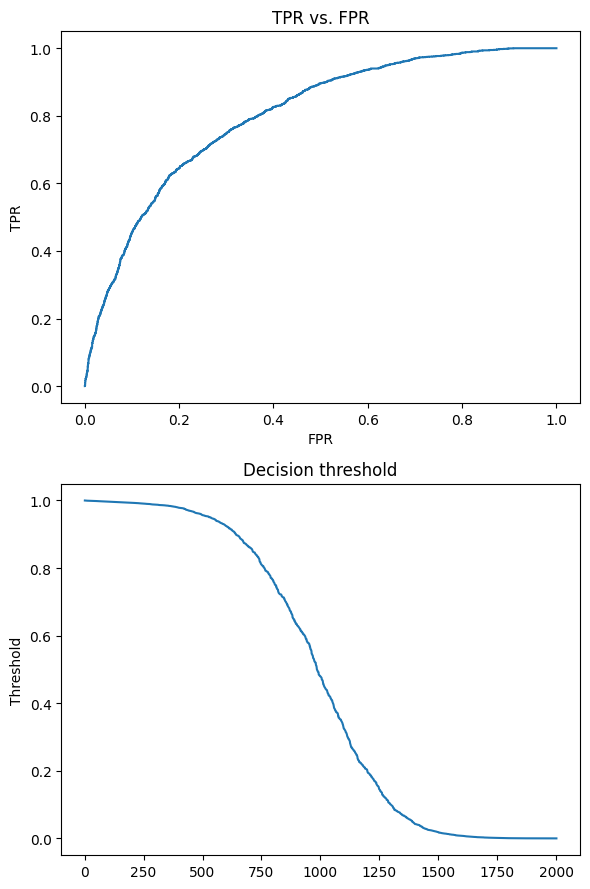

In [82]:
import matplotlib.pyplot as plt

# Sample data
array1 = roc[0]
array2 = roc[1]
array3 = roc[2]

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 9))

# Plot array1 and array2 together
axs[0].plot(array1, array2)
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_title('TPR vs. FPR')

# Plot array3 on top with a different scale
axs[1].plot(array3)
# axs[1].set_xlabel('X')
axs[1].set_ylabel('Threshold')
# axs[1].set_yscale('log')
axs[1].set_title('Decision threshold')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Other classifiers

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

"Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers."

## SVC, SVM
Effective in high dimensional spaces.

Still effective in cases where number of dimensions is greater than the number of samples.

In [11]:
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support

file_list = [
    # 'power-ba-train.tsv',
    # 'power-rs-train.tsv',
    # 'power-hr-train.tsv',
    'power-gb-train.tsv'
]

data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text')
train_raw, test_raw = split_data(data, test_size=0.2, random_state=0)

print("fit count vectorizer")
# count_vectorizer = CountVectorizer().fit(train_raw.texts)
tfidf_vectorizer = TfidfVectorizer().fit(train_raw.texts)

# X_count = count_vectorizer.transform(train_raw.texts)
X_tfidf = tfidf_vectorizer.transform(train_raw.texts)


fit count vectorizer


In [ ]:
# SVC, count, very slow
# print("fit model")
# model_svc_count = SVC()
# model_svc_count.fit(X_count, train_raw.labels)

# pred_svc_count = model_svc_count.predict(count_vectorizer.transform(test_raw.texts))

# precision_recall_fscore_support(test_raw.labels, pred_svc_count, average='binary')


In [ ]:
# SVC, tfidf
print("fit model")
model_svc_tfidf = SVC()
model_svc_tfidf.fit(X_tfidf, train_raw.labels)

pred_svc_tfidf = model_svc_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts))

precision_recall_fscore_support(test_raw.labels, pred_svc_tfidf, average='binary')


LinearSVC with TfIdf did good on balanced English

In [13]:
from sklearn.svm import LinearSVC
# LinearSVC, tfidf
print("fit model")
model_LinearSVC_tfidf = LinearSVC()
model_LinearSVC_tfidf.fit(X_tfidf, train_raw.labels)

pred_LinearSVC_tfidf = model_LinearSVC_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts))

precision_recall_fscore_support(test_raw.labels, pred_LinearSVC_tfidf, average='binary')


fit model


NameError: name 'LinearSVC' is not defined

Test this fast method with balkan data. Looks like by default, even with rebalancing, neural network model performs better

In [30]:
# LinearSVC, tfidf, balkan

file_list = [
    'power-ba-train.tsv',
    'power-rs-train.tsv',
    'power-hr-train.tsv',
    # 'power-gb-train.tsv'
]

data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text')
train_raw, test_raw = split_data(data, test_size=0.2, random_state=0)

print("Positive ratio:", sum(train_raw.labels) / len(train_raw))

weight_0 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 0))
weight_1 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 1))

print(weight_0, weight_1)

print("fit vectorizer")
count_vectorizer = CountVectorizer().fit(train_raw.texts)
tfidf_vectorizer = TfidfVectorizer().fit(train_raw.texts)

X_count = count_vectorizer.transform(train_raw.texts)
X_tfidf = tfidf_vectorizer.transform(train_raw.texts)

print("fit model")
model_LinearSVC_tfidf = LinearSVC()
model_LinearSVC_count.fit(X_count, train_raw.labels, sample_weight=[weight_0 if i == 0 else weight_1 for i in train_raw.labels])
model_LinearSVC_tfidf.fit(X_tfidf, train_raw.labels, sample_weight=[weight_0 if i == 0 else weight_1 for i in train_raw.labels])

pred_LinearSVC_count = model_LinearSVC_count.predict(count_vectorizer.transform(test_raw.texts))
pred_LinearSVC_tfidf = model_LinearSVC_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts))

print(precision_recall_fscore_support(test_raw.labels, pred_LinearSVC_count, average='binary'))
print(precision_recall_fscore_support(test_raw.labels, pred_LinearSVC_tfidf, average='binary'))


Positive ratio: 0.3698394495412844
0.7934485896269335 1.3519379844961241
fit vectorizer
fit model


/home/hapham/.pyenv/versions/3.11.5/envs/power/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(0.6140350877192983, 0.6054781355117732, 0.6097265908541012, None)
(0.6483568075117371, 0.6636232580490149, 0.6559012111137497, None)


## SGDClassifier
SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

SGD is sensitive to feature scaling.

In [11]:
from sklearn.linear_model import SGDClassifier

file_list = [
    # 'power-ba-train.tsv',
    # 'power-rs-train.tsv',
    # 'power-hr-train.tsv',
    'power-gb-train.tsv'
]

data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text')
train_raw, test_raw = split_data(data, test_size=0.2, random_state=0)

print("Positive ratio:", sum(train_raw.labels) / len(train_raw))

weight_0 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 0))
weight_1 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 1))

print(weight_0, weight_1)

print("fit vectorizer")
tfidf_vectorizer = TfidfVectorizer().fit(train_raw.texts)

X_tfidf = tfidf_vectorizer.transform(train_raw.texts)

print("fit model")
model_SGDClassifier_tfidf = SGDClassifier()
model_SGDClassifier_tfidf.fit(X_tfidf, train_raw.labels)

pred_SGDClassifier_tfidf = model_SGDClassifier_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts))

print(precision_recall_fscore_support(test_raw.labels, pred_SGDClassifier_tfidf, average='binary'))

roc_auc_score(test_raw.labels, pred_SGDClassifier_tfidf)


Positive ratio: 0.5651684127520559
1.1498704663212436 0.8846920470400638
fit vectorizer
fit model
(0.7389128951557881, 0.8778708457173737, 0.8024203507038775, None)


0.7426961066193706

Test on balkan, not so good

In [9]:
from sklearn.linear_model import SGDClassifier

file_list = [
    'power-ba-train.tsv',
    'power-rs-train.tsv',
    'power-hr-train.tsv',
    # 'power-gb-train.tsv'
]

data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text')
train_raw, test_raw = split_data(data, test_size=0.2, random_state=0)

print("Positive ratio:", sum(train_raw.labels) / len(train_raw))

weight_0 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 0))
weight_1 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 1))

print(weight_0, weight_1)

print("fit vectorizer")
tfidf_vectorizer = TfidfVectorizer().fit(train_raw.texts)

X_tfidf = tfidf_vectorizer.transform(train_raw.texts)

print("fit model")
model_SGDClassifier_tfidf = SGDClassifier()
model_SGDClassifier_tfidf.fit(X_tfidf, train_raw.labels)

pred_SGDClassifier_tfidf = model_SGDClassifier_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts))

print(precision_recall_fscore_support(test_raw.labels, pred_SGDClassifier_tfidf, average='binary'))
roc_auc_score(test_raw.labels, pred_SGDClassifier_tfidf)

Positive ratio: 0.3698394495412844
0.7934485896269335 1.3519379844961241
fit vectorizer
fit model
(0.7608261159227182, 0.5487746275828929, 0.6376326074818537, None)


0.7249791112040531

## Naive Bayes

Overall bad performance, not worth pursuing

In [4]:
from sklearn.naive_bayes import GaussianNB

file_list = [
    # 'power-ba-train.tsv',
    # 'power-rs-train.tsv',
    # 'power-hr-train.tsv',
    'power-gb-train.tsv'
]

data = load_data(folder_path="data/train/power/", file_list=file_list,text_head='text')
train_raw, test_raw = split_data(data, test_size=0.2, random_state=0)

print("Positive ratio:", sum(train_raw.labels) / len(train_raw))

weight_0 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 0))
weight_1 = len(train_raw) / (2 * sum(np.array(train_raw.labels) == 1))

print(weight_0, weight_1)

print("fit vectorizer")
tfidf_vectorizer = TfidfVectorizer().fit(train_raw.texts)

X_tfidf = tfidf_vectorizer.transform(train_raw.texts)

print("fit model")
model_GaussianNB_tfidf = GaussianNB()
model_GaussianNB_tfidf.fit(X_tfidf.toarray(), train_raw.labels)

pred_GaussianNB_tfidf = model_GaussianNB_tfidf.predict(tfidf_vectorizer.transform(test_raw.texts).toarray())

print(precision_recall_fscore_support(test_raw.labels, pred_GaussianNB_tfidf, average='binary'))
roc_auc_score(test_raw.labels, pred_GaussianNB_tfidf)

Positive ratio: 0.5651684127520559
1.1498704663212436 0.8846920470400638
fit vectorizer
fit model
(0.6212948517940717, 0.43042420967306133, 0.5085395051875499, None)


0.5492291988536246

# Conclusions

- Neural network is still a good option
- sklearn's SGD is also good